In [1]:
from PIL import Image
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import numpy as np
import torchvision
from torchvision import transforms
from glob import glob
import cv2
import random

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,plot_confusion_matrix

import time
import copy

In [2]:
def seed(seed = 42):
    random.seed(seed) # python random seed 고정
    os.environ['PYTHONHASHSEED'] = str(seed) # os 자체의 seed 고정
    np.random.seed(seed) # numpy seed 고정 
    torch.manual_seed(seed) # torch seed 고정
    torch.cuda.manual_seed(seed) # cudnn seed 고정
    torch.backends.cudnn.deterministic = True # cudnn seed 고정(nn.Conv2d)
    torch.backends.cudnn.benchmark = False # CUDA 내부 연산에서 가장 빠른 알고리즘을 찾아 수행

## DataLoader worker에 대한 seed 설정
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)
    
seed()

In [9]:
train_normal_path = '/mnt/nas100_vol2/LeeJungHoon/AOV_task(binary_clssification)/AOV_data/Aov_task_curation_data/curation_data_v4/data_v4_7_1/normal_train_v4/*.jpg'
train_abnormal_path ='/mnt/nas100_vol2/LeeJungHoon/AOV_task(binary_clssification)/AOV_data/Aov_task_curation_data/curation_data_v4/data_v4_7_1/abnormal_train_v4/*.jpg'
valid_normal_path ='/mnt/nas100_vol2/LeeJungHoon/AOV_task(binary_clssification)/AOV_data/Aov_task_curation_data/curation_data_v4/data_v4_7_1/normal_val_v4/*.jpg'
valid_abnormal_path ='/mnt/nas100_vol2/LeeJungHoon/AOV_task(binary_clssification)/AOV_data/Aov_task_curation_data/curation_data_v4/data_v4_7_1/abnormal_val_v4/*.jpg'
test_normal_path ='/mnt/nas100_vol2/LeeJungHoon/AOV_task(binary_clssification)/AOV_data/Aov_task_curation_data/curation_data_v4/data_v4_7_1/normal_test_v4/*.jpg'
test_abnormal_path ='/mnt/nas100_vol2/LeeJungHoon/AOV_task(binary_clssification)/AOV_data/Aov_task_curation_data/curation_data_v4/data_v4_7_1/abnormal_test_v4/*.jpg'

In [10]:
train_normal_glob = glob(train_normal_path)
train_abnormal_glob = glob(train_abnormal_path)
val_normal_glob = glob(valid_normal_path)
val_abnormal_glob = glob(valid_abnormal_path)
test_normal_glob = glob(test_normal_path)
test_abnormal_glob = glob(test_abnormal_path)

print('train_normal :', len(train_normal_glob))
print('val_normal :', len(val_normal_glob))
print('test_normal :', len(test_normal_glob))
print('------------------------------------')
print('train_abnormal :', len(train_abnormal_glob))
print('val_abnormal :', len(val_abnormal_glob))
print('test_abnormal :', len(test_abnormal_glob))

train_normal : 419
val_normal : 95
test_normal : 76
------------------------------------
train_abnormal : 352
val_abnormal : 75
test_abnormal : 78


In [11]:
print(os.getcwd())

/mnt/nas100_vol2/LeeJungHoon/AOV_task(binary_clssification)/Model_V2/base_seed


In [12]:
class Aov_Dysplasia_dataset(Dataset):
    def __init__(self, normal_path, abnormal_path, transform=None):
        #생성자, 데이터를 전처리 
        self.normal_path_list = glob(normal_path)
        self.abnormal_path_list = glob(abnormal_path)
        print(len(self.normal_path_list))
#         self.mode = mode 
    
#         label = np.array([[0, 1], [1, 0]], dtype=np.float32)
        
#         self.label_list = []
#         for i in self.normal_path_list:
#             self.label_list.append(label[0])
            
#         for i in self.abnormal_path_list:
#             self.label_list.append(label[1])
            
        label_policy = {
            'normal': 0, 
            'abnormal': 1
        }
    
        self.label_list= []
        
        for i in self.normal_path_list:
            self.label_list.append(label_policy["normal"])
            
        for i in self.abnormal_path_list:
            self.label_list.append(label_policy["abnormal"])
        
        self.total_img_path_list = self.normal_path_list + self.abnormal_path_list
        self.transform = transform
    
    def __len__(self):
        return len(self.total_img_path_list)
    
    def __getitem__(self, idx):
        
        img = cv2.imread(self.total_img_path_list[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # img = np.array(img, dtype=np.float32)
        #들어오는 이미지의 컬러 형태가 BGR인지 RGB인지 모르기때문에 변형

        
        label = self.label_list[idx]
        
        if self.transform is not None:
            transformed = self.transform(image=img)
            img = transformed['image'] 
            img = torch.tensor(np.array(img), dtype=torch.float32)
            # img = torch.FloatTensor(img)
            img = (img - torch.min(img)) / (torch.max(img)-torch.min(img))
            
            return {'img': img, 'label': label, 'filename': self.total_img_path_list[idx]}
        
        else:
            # img = transformed['image']
            img = torch.tensor(np.array(img), dtype=torch.float32)
            # img = torch.FloatTensor(img)
            img = (img - torch.min(img)) / (torch.max(img)-torch.min(img))
            return{'img': img, 'label': label}

In [7]:
a = torch.randint(1,10, size=(2,3,4))
b= torch.FloatTensor(a)
print(a)
print(torch.min(a))
print(a-torch.min(a))

TypeError: expected TensorOptions(dtype=float, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) (got TensorOptions(dtype=long int, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)))

In [13]:
#https://albumentations.ai/docs/api_reference/augmentations/transforms/
import albumentations as A 
from  albumentations.pytorch import ToTensorV2

train_transform = A.Compose(
    [
        # Contrast Limited Adaptive Histogram Equalization 적용
#     A.CLAHE(p=1,clip_limit=(1, 3)),
#     A.HorizontalFlip(p=0.3),
    A.Resize(224,224, interpolation = cv2.INTER_AREA),
    A.ShiftScaleRotate(shift_limit=0, scale_limit=(0.1, 0.2), rotate_limit=0, p=0.6, border_mode=cv2.BORDER_REPLICATE),
    A.CLAHE(clip_limit=(1, 2), p=0.6),
    A.RandomRotate90(p=0.7),
    A.VerticalFlip(p=0.7),
    A.HorizontalFlip(p=0.7),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.3),
    # A.Normalize()
    ToTensorV2()
    ])

valid_transform = A.Compose(
    [
        A.Resize(224,224, interpolation = cv2.INTER_AREA),
        ToTensorV2()
    ])

test_transform = A.Compose(
    [
        A.Resize(224,224, interpolation = cv2.INTER_AREA),
        ToTensorV2()
    ])

In [14]:
train_dataset = Aov_Dysplasia_dataset(train_normal_path, train_abnormal_path, transform = train_transform)
valid_dataset = Aov_Dysplasia_dataset(valid_normal_path, valid_abnormal_path, transform = valid_transform)
test_dataset = Aov_Dysplasia_dataset(test_normal_path, test_abnormal_path, transform = test_transform)

419
95
76


In [15]:
# 각 dataset에서의 label값만 추출
train_label_count = []
for i in range(len(train_dataset)):
    label = train_dataset[i]['label']
    train_label_count.append(label)
    
print(len(train_label_count))

sum_train = len(train_label_count)


train_0_counts = train_label_count.count(0)
train_1_counts = train_label_count.count(1)

print('train label 0 :', train_0_counts)
print('train label 1 :',train_1_counts)

#클래스별 가중치 부여 => class 1에 가중치 높게 부여하게 됨
train_0_weight = []
train_1_weight = []
train_weight = []

train_0_weight.append(sum_train / train_0_counts) 
train_1_weight.append(sum_train / train_1_counts)

train_weight = train_0_weight + train_1_weight

print(train_weight)



771
train label 0 : 419
train label 1 : 352
[1.8400954653937946, 2.190340909090909]


In [16]:
train_label_count

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [17]:
# 해당 데이터의 label에 해당되는 가중치
weights = [train_weight[train_label_count[i]] for i in range(int(sum_train))] #해당 레이블마다의 가중치 비율
sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(sum_train))

In [18]:
weights

[1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653937946,
 1.8400954653

In [19]:
#dataloader 생성
batch_size= 16
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, worker_init_fn=seed_worker)
train_dataloader_no = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle = True, worker_init_fn=seed_worker)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle = True, worker_init_fn=seed_worker)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle = False ,worker_init_fn=seed_worker)

In [20]:
print('train_dataset :',len(train_dataset))
print('valid_dataset :',len(valid_dataset))
print('test_dataset :',len(test_dataset))

train_dataset : 771
valid_dataset : 170
test_dataset : 154


In [21]:
a= 0

for data in train_dataloader:
    print(data['label'])
    a+=1        
    
    if a == 10:
        break

tensor([0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0])
tensor([1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
tensor([0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1])
tensor([1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0])
tensor([0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1])
tensor([1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1])
tensor([1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0])
tensor([0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0])
tensor([0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0])
tensor([1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0])


In [22]:
len(train_dataloader)

49

1
<built-in method type of Tensor object at 0x7ffaaf002e08>
(224, 224, 3)
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
tensor(1)


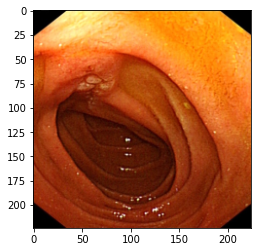

<built-in method type of Tensor object at 0x7ffaaf002e08>
(224, 224, 3)
[[[0.34117648 0.03137255 0.        ]
  [0.33333334 0.02352941 0.        ]
  [0.31764707 0.05490196 0.        ]
  ...
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]]

 [[0.3137255  0.         0.        ]
  [0.32941177 0.06666667 0.        ]
  [0.58431375 0.35686275 0.29411766]
  ...
  [0.02352941 0.02352941 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]]

 [[0.3764706  0.08627451 0.05882353]
  [0.52156866 0.29411766 0.23921569]
  [0.7607843  0.57254905 0.5058824 ]
  ...
  [0.02352941 0.02352941 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]]

 ...

 [[0.67058825 0.         0.        ]
  [0.67058825 0.         0.        ]
  [0.6862745  0.09019608 0.        ]
  ...
  [0.02352941 0.02745098 0.02745098]
  [0.01568628 0.01568628 0.01568628]
  [0.01568628 0.01568628 0.01568628]]

 [

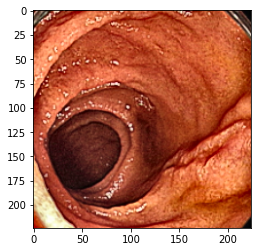

<built-in method type of Tensor object at 0x7ffaaf002e08>
(224, 224, 3)
[[[0.78039217 0.3529412  0.20392157]
  [0.78431374 0.35686275 0.19607843]
  [0.8039216  0.3764706  0.21568628]
  ...
  [0.6784314  0.24705882 0.14509805]
  [0.6039216  0.19607843 0.10588235]
  [0.79607844 0.50980395 0.41960785]]

 [[0.7882353  0.36078432 0.20784314]
  [0.7882353  0.36078432 0.2       ]
  [0.79607844 0.3647059  0.20392157]
  ...
  [0.8        0.31764707 0.18431373]
  [0.72156864 0.2509804  0.11372549]
  [0.6745098  0.30980393 0.19215687]]

 [[0.7882353  0.35686275 0.20392157]
  [0.80784315 0.3764706  0.21176471]
  [0.83137256 0.39215687 0.23137255]
  ...
  [0.8627451  0.35686275 0.20392157]
  [0.8156863  0.3137255  0.15294118]
  [0.7058824  0.28627452 0.14901961]]

 ...

 [[0.05490196 0.01176471 0.00392157]
  [0.16862746 0.01960784 0.00784314]
  [0.3254902  0.07450981 0.04705882]
  ...
  [0.3137255  0.07450981 0.05098039]
  [0.33333334 0.10980392 0.09019608]
  [0.18431373 0.04313726 0.03529412]]

 [

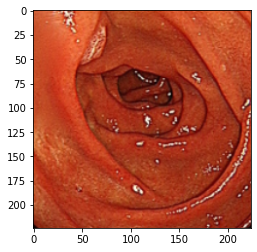

<built-in method type of Tensor object at 0x7ffaaf002e08>
(224, 224, 3)
[[[0.5019608  0.09411765 0.05490196]
  [0.5019608  0.09411765 0.05490196]
  [0.5254902  0.09019608 0.05882353]
  ...
  [0.627451   0.18039216 0.07450981]
  [0.62352943 0.18431373 0.07450981]
  [0.61960787 0.19215687 0.0627451 ]]

 [[0.50980395 0.09019608 0.05098039]
  [0.5294118  0.08235294 0.05882353]
  [0.5529412  0.09411765 0.05882353]
  ...
  [0.64705884 0.19607843 0.07843138]
  [0.62352943 0.18431373 0.05490196]
  [0.627451   0.2        0.0627451 ]]

 [[0.53333336 0.09019608 0.05098039]
  [0.5686275  0.11372549 0.07058824]
  [0.5882353  0.12156863 0.0627451 ]
  ...
  [0.6627451  0.21960784 0.10196079]
  [0.63529414 0.19215687 0.07058824]
  [0.627451   0.18039216 0.07450981]]

 ...

 [[0.9882353  0.98039216 0.5568628 ]
  [0.9882353  0.98039216 0.5568628 ]
  [0.9882353  0.98039216 0.5568628 ]
  ...
  [0.9882353  0.99607843 0.34117648]
  [1.         1.         0.38039216]
  [1.         1.         0.4       ]]

 [

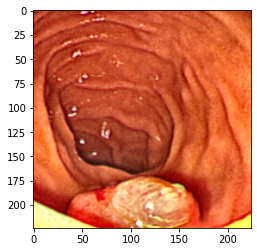

<built-in method type of Tensor object at 0x7ffaaf002e08>
(224, 224, 3)
[[[0.01568628 0.01568628 0.01568628]
  [0.02352941 0.00784314 0.01960784]
  [0.05490196 0.02352941 0.00784314]
  ...
  [0.20392157 0.07843138 0.03529412]
  [0.07843138 0.02352941 0.01176471]
  [0.01176471 0.01176471 0.01176471]]

 [[0.02352941 0.01568628 0.00784314]
  [0.08235294 0.03137255 0.02352941]
  [0.19607843 0.10980392 0.08627451]
  ...
  [0.43529412 0.19215687 0.1254902 ]
  [0.23137255 0.10588235 0.0627451 ]
  [0.09411765 0.03921569 0.01960784]]

 [[0.09803922 0.05098039 0.03921569]
  [0.22745098 0.13725491 0.10588235]
  [0.44313726 0.27058825 0.21176471]
  ...
  [0.6627451  0.28235295 0.16470589]
  [0.4745098  0.21176471 0.12941177]
  [0.27450982 0.1254902  0.07843138]]

 ...

 [[0.08627451 0.01568628 0.01568628]
  [0.16862746 0.03137255 0.01568628]
  [0.27450982 0.03529412 0.00392157]
  ...
  [0.57254905 0.2        0.13725491]
  [0.35686275 0.0627451  0.02745098]
  [0.22745098 0.01176471 0.        ]]

 [

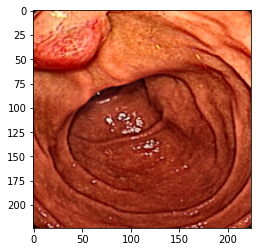

<built-in method type of Tensor object at 0x7ffaaf002e08>
(224, 224, 3)
[[[0.995 0.62  0.275]
  [1.    0.62  0.275]
  [1.    0.62  0.265]
  ...
  [0.51  0.2   0.105]
  [0.5   0.19  0.1  ]
  [0.495 0.2   0.105]]

 [[0.995 0.62  0.26 ]
  [1.    0.625 0.27 ]
  [1.    0.63  0.265]
  ...
  [0.515 0.205 0.105]
  [0.505 0.195 0.105]
  [0.5   0.2   0.105]]

 [[0.995 0.62  0.26 ]
  [0.995 0.615 0.26 ]
  [1.    0.63  0.27 ]
  ...
  [0.53  0.215 0.12 ]
  [0.52  0.195 0.105]
  [0.51  0.2   0.1  ]]

 ...

 [[0.99  0.99  0.98 ]
  [0.985 0.985 0.955]
  [0.995 0.99  0.95 ]
  ...
  [0.55  0.185 0.095]
  [0.55  0.195 0.1  ]
  [0.54  0.2   0.1  ]]

 [[0.98  0.98  0.965]
  [0.98  0.98  0.92 ]
  [0.985 0.98  0.885]
  ...
  [0.545 0.18  0.085]
  [0.535 0.19  0.1  ]
  [0.52  0.195 0.095]]

 [[0.935 0.935 0.915]
  [0.975 0.975 0.915]
  [0.98  0.985 0.865]
  ...
  [0.535 0.185 0.085]
  [0.525 0.195 0.1  ]
  [0.48  0.185 0.1  ]]]
tensor(1)


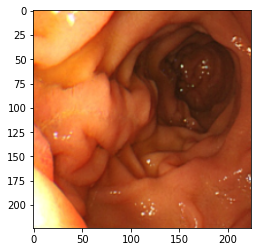

<built-in method type of Tensor object at 0x7ffaaf002e08>
(224, 224, 3)
[[[0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  ...
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]]

 [[0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  ...
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]]

 [[0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  ...
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]]

 ...

 [[0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  ...
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]]

 [

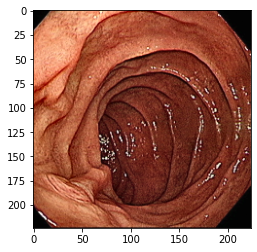

<built-in method type of Tensor object at 0x7ffaaf002e08>
(224, 224, 3)
[[[0.8039216  0.3372549  0.16862746]
  [0.83137256 0.33333334 0.16862746]
  [0.67058825 0.19607843 0.07450981]
  ...
  [0.99607843 0.72156864 0.57254905]
  [0.99607843 0.6901961  0.5254902 ]
  [0.92156863 0.654902   0.4862745 ]]

 [[0.81960785 0.30588236 0.15686275]
  [0.5803922  0.07843138 0.        ]
  [0.5176471  0.08235294 0.00392157]
  ...
  [1.         0.88235295 0.74509805]
  [1.         0.7411765  0.5803922 ]
  [1.         0.7176471  0.54509807]]

 [[0.627451   0.11764706 0.00392157]
  [0.6862745  0.30588236 0.20784314]
  [0.90588236 0.6431373  0.56078434]
  ...
  [1.         0.9607843  0.85882354]
  [1.         0.7647059  0.627451  ]
  [1.         0.69803923 0.5411765 ]]

 ...

 [[0.59607846 0.1882353  0.08627451]
  [0.63529414 0.21568628 0.11372549]
  [0.7019608  0.2627451  0.16862746]
  ...
  [0.78039217 0.3647059  0.24705882]
  [0.7921569  0.36862746 0.2627451 ]
  [0.8        0.4117647  0.3137255 ]]

 [

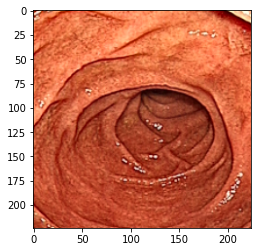

<built-in method type of Tensor object at 0x7ffaaf002e08>
(224, 224, 3)
[[[0.02777778 0.00396825 0.00793651]
  [0.09920635 0.03571429 0.03174603]
  [0.18650794 0.06349207 0.04761905]
  ...
  [0.8611111  0.65873015 0.43253967]
  [0.6626984  0.5119048  0.36507937]
  [0.28174603 0.17857143 0.12698413]]

 [[0.08730159 0.02380952 0.02380952]
  [0.18650794 0.08333334 0.07142857]
  [0.24206349 0.08730159 0.06746032]
  ...
  [0.9484127  0.71428573 0.44047618]
  [0.88492066 0.68650794 0.4484127 ]
  [0.7222222  0.5515873  0.37301588]]

 [[0.15079366 0.04365079 0.03571429]
  [0.2579365  0.12698413 0.09920635]
  [0.35714287 0.1904762  0.15476191]
  ...
  [0.98015875 0.734127   0.41666666]
  [0.96428573 0.734127   0.44047618]
  [0.92460316 0.71031743 0.45238096]]

 ...

 [[0.16269842 0.11111111 0.0952381 ]
  [0.2857143  0.17857143 0.15476191]
  [0.3809524  0.20238096 0.16666667]
  ...
  [0.85714287 0.5674603  0.35714287]
  [0.8015873  0.57539684 0.43253967]
  [0.6626984  0.5119048  0.44047618]]

 [

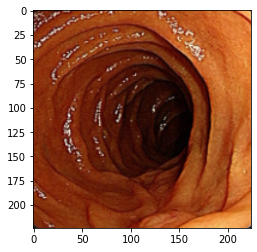

<built-in method type of Tensor object at 0x7ffaaf002e08>
(224, 224, 3)
[[[0.54260087 0.18834081 0.09865471]
  [0.5605381  0.19730942 0.11210762]
  [0.57399106 0.21076234 0.12556054]
  ...
  [0.50672644 0.25112107 0.19730942]
  [0.2780269  0.12107623 0.09865471]
  [0.08520179 0.00896861 0.00448431]]

 [[0.5695067  0.21076234 0.11659193]
  [0.57399106 0.21076234 0.11210762]
  [0.54260087 0.1748879  0.07623319]
  ...
  [0.5201794  0.21524663 0.16143498]
  [0.42152467 0.18834081 0.16143498]
  [0.21076234 0.07623319 0.05829597]]

 [[0.6233184  0.24663678 0.14798206]
  [0.6098655  0.22421524 0.12107623]
  [0.5201794  0.13452914 0.01793722]
  ...
  [0.5381166  0.18834081 0.13901345]
  [0.49775785 0.17937219 0.14349777]
  [0.38116592 0.16591929 0.13452914]]

 ...

 [[0.47085202 0.06278027 0.        ]
  [0.5156951  0.11210762 0.05381166]
  [0.59192824 0.20627803 0.13004485]
  ...
  [0.85650223 0.41704035 0.2780269 ]
  [0.9013453  0.4529148  0.2825112 ]
  [0.85650223 0.43049327 0.24215247]]

 [

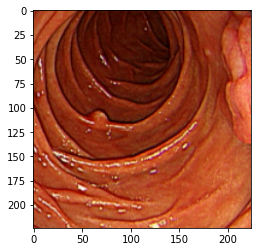

<built-in method type of Tensor object at 0x7ffaaf002e08>
(224, 224, 3)
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
tensor(1)


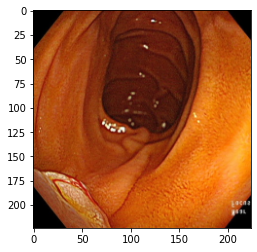

<built-in method type of Tensor object at 0x7ffaaf002e08>
(224, 224, 3)
[[[0.6117647  0.24313726 0.07450981]
  [0.5921569  0.23529412 0.0627451 ]
  [0.61960787 0.28235295 0.12156863]
  ...
  [0.42352942 0.07058824 0.02352941]
  [0.38431373 0.02352941 0.        ]
  [0.3372549  0.         0.        ]]

 [[0.6313726  0.25882354 0.08235294]
  [0.62352943 0.2627451  0.09019608]
  [0.69803923 0.3647059  0.21568628]
  ...
  [0.4509804  0.09019608 0.05098039]
  [0.39607844 0.02352941 0.        ]
  [0.36078432 0.         0.        ]]

 [[0.61960787 0.2509804  0.08627451]
  [0.627451   0.27450982 0.09803922]
  [0.7764706  0.47058824 0.31764707]
  ...
  [0.54901963 0.17254902 0.13333334]
  [0.40392157 0.05098039 0.02352941]
  [0.36078432 0.02745098 0.00784314]]

 ...

 [[0.01176471 0.01176471 0.01176471]
  [0.02352941 0.02352941 0.02352941]
  [0.02352941 0.02352941 0.02352941]
  ...
  [0.02352941 0.02352941 0.02352941]
  [0.02352941 0.02352941 0.02352941]
  [0.01176471 0.01176471 0.01176471]]

 [

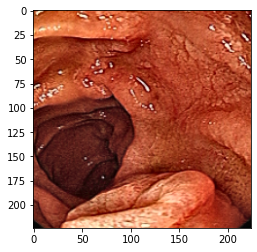

<built-in method type of Tensor object at 0x7ffaaf002e08>
(224, 224, 3)
[[[0.00784314 0.01568628 0.01176471]
  [0.00784314 0.01568628 0.01176471]
  [0.00784314 0.01176471 0.01176471]
  ...
  [0.01176471 0.01960784 0.01568628]
  [0.00784314 0.01568628 0.01176471]
  [0.00784314 0.01568628 0.01176471]]

 [[0.00784314 0.01568628 0.01176471]
  [0.00392157 0.01176471 0.00784314]
  [0.00392157 0.01176471 0.01176471]
  ...
  [0.01176471 0.01960784 0.01568628]
  [0.01176471 0.01960784 0.01568628]
  [0.01176471 0.01960784 0.01568628]]

 [[0.01176471 0.01960784 0.01568628]
  [0.01176471 0.01960784 0.01568628]
  [0.00784314 0.01568628 0.01176471]
  ...
  [0.01568628 0.01568628 0.01568628]
  [0.01568628 0.01568628 0.01568628]
  [0.01568628 0.01568628 0.01568628]]

 ...

 [[0.01960784 0.01960784 0.01960784]
  [0.01960784 0.01960784 0.01960784]
  [0.01960784 0.01960784 0.01960784]
  ...
  [0.01960784 0.01960784 0.01960784]
  [0.02352941 0.02352941 0.01960784]
  [0.02352941 0.02352941 0.01960784]]

 [

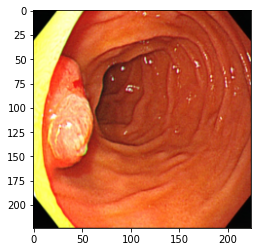

<built-in method type of Tensor object at 0x7ffaaf002e08>
(224, 224, 3)
[[[0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  ...
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]]

 [[0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  ...
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]]

 [[0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  ...
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]]

 ...

 [[0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  ...
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]]

 [

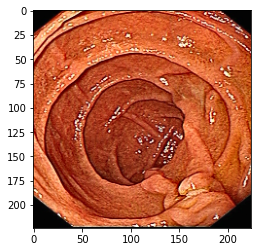

<built-in method type of Tensor object at 0x7ffaaf002e08>
(224, 224, 3)
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
tensor(1)


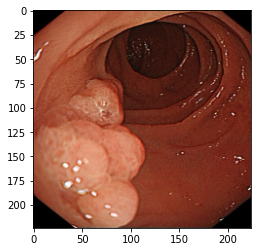

<built-in method type of Tensor object at 0x7ffaaf002e08>
(224, 224, 3)
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
tensor(0)


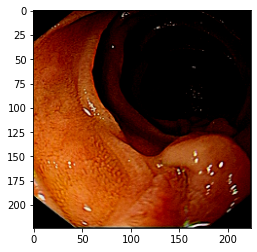

2
<built-in method type of Tensor object at 0x7ffaac1e6ea8>
(224, 224, 3)
[[[0.01568628 0.00784314 0.        ]
  [0.02352941 0.02352941 0.01176471]
  [0.23137255 0.1764706  0.16862746]
  ...
  [0.21568628 0.04313726 0.00784314]
  [0.06666667 0.00784314 0.00392157]
  [0.00784314 0.00784314 0.00784314]]

 [[0.03529412 0.00784314 0.01568628]
  [0.16862746 0.11372549 0.11764706]
  [0.38431373 0.24705882 0.22352941]
  ...
  [0.3764706  0.12941177 0.06666667]
  [0.18039216 0.03921569 0.01568628]
  [0.04705882 0.01568628 0.01176471]]

 [[0.12156863 0.09019608 0.08627451]
  [0.52156866 0.4        0.4       ]
  [0.46666667 0.23921569 0.20392157]
  ...
  [0.5137255  0.23137255 0.13333334]
  [0.32941177 0.12941177 0.07843138]
  [0.14117648 0.02352941 0.02352941]]

 ...

 [[0.03529412 0.00784314 0.01568628]
  [0.07843138 0.03921569 0.05098039]
  [0.23921569 0.14509805 0.13333334]
  ...
  [0.26666668 0.0627451  0.00392157]
  [0.12941177 0.02352941 0.01568628]
  [0.03921569 0.01568628 0.02352941]]



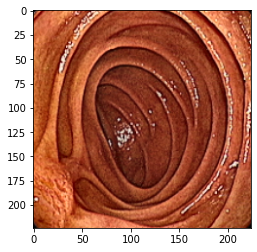

<built-in method type of Tensor object at 0x7ffaac1e6ea8>
(224, 224, 3)
[[[0.01568628 0.01568628 0.01568628]
  [0.01568628 0.01568628 0.01568628]
  [0.01568628 0.01568628 0.01568628]
  ...
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]]

 [[0.01568628 0.01568628 0.01568628]
  [0.01568628 0.01568628 0.01568628]
  [0.01568628 0.01568628 0.01568628]
  ...
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]]

 [[0.01568628 0.01568628 0.01568628]
  [0.01568628 0.01568628 0.01568628]
  [0.01568628 0.01568628 0.01568628]
  ...
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]]

 ...

 [[0.01568628 0.01568628 0.01568628]
  [0.01568628 0.01568628 0.01568628]
  [0.01568628 0.01568628 0.01568628]
  ...
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]]

 [

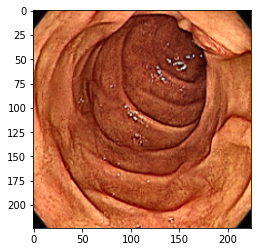

<built-in method type of Tensor object at 0x7ffaac1e6ea8>
(224, 224, 3)
[[[0.47131148 0.38934427 0.28278688]
  [0.4795082  0.34016395 0.20491803]
  [0.46721312 0.27868852 0.1352459 ]
  ...
  [0.58196723 0.26639345 0.1762295 ]
  [0.57377046 0.26639345 0.17213115]
  [0.5696721  0.2581967  0.17213115]]

 [[0.45491803 0.32786885 0.2090164 ]
  [0.48770493 0.3114754  0.18852459]
  [0.5        0.28688523 0.1557377 ]
  ...
  [0.59836066 0.29508197 0.20081967]
  [0.5778689  0.28688523 0.19262294]
  [0.57377046 0.27868852 0.18852459]]

 [[0.4795082  0.26639345 0.15983607]
  [0.545082   0.28278688 0.18442623]
  [0.602459   0.31557378 0.22131148]
  ...
  [0.60655737 0.28688523 0.19262294]
  [0.5942623  0.28688523 0.19672132]
  [0.59016395 0.26639345 0.18852459]]

 ...

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         0.98770493]
  ...
  [0.90163934 0.5        0.29918033]
  [0.8442623  0.43442622 0.26639345]
  [0.83196723 0.40163934 0.26229507]]

 [

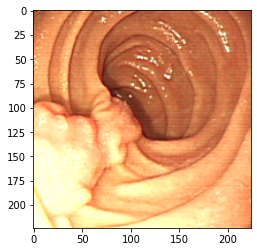

<built-in method type of Tensor object at 0x7ffaac1e6ea8>
(224, 224, 3)
[[[0.00784314 0.00392157 0.00392157]
  [0.01176471 0.00392157 0.00784314]
  [0.02745098 0.00392157 0.00784314]
  ...
  [0.07450981 0.01568628 0.01176471]
  [0.02352941 0.00784314 0.00784314]
  [0.00784314 0.00392157 0.00784314]]

 [[0.01176471 0.00392157 0.00392157]
  [0.02745098 0.00784314 0.00784314]
  [0.06666667 0.01176471 0.00784314]
  ...
  [0.23137255 0.07058824 0.0627451 ]
  [0.09411765 0.01960784 0.02352941]
  [0.02352941 0.         0.01176471]]

 [[0.03921569 0.00784314 0.00784314]
  [0.09019608 0.02352941 0.01568628]
  [0.16470589 0.04313726 0.02745098]
  ...
  [0.43529412 0.16470589 0.12941177]
  [0.2627451  0.08235294 0.07058824]
  [0.11764706 0.02352941 0.02745098]]

 ...

 [[0.01960784 0.00784314 0.01960784]
  [0.05098039 0.03921569 0.04313726]
  [0.21176471 0.2        0.19607843]
  ...
  [0.50980395 0.36078432 0.31764707]
  [0.25882354 0.1882353  0.17254902]
  [0.07843138 0.05490196 0.05098039]]

 [

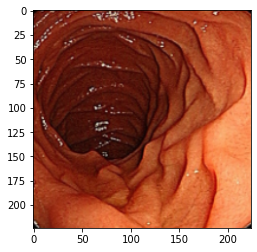

<built-in method type of Tensor object at 0x7ffaac1e6ea8>
(224, 224, 3)
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
tensor(0)


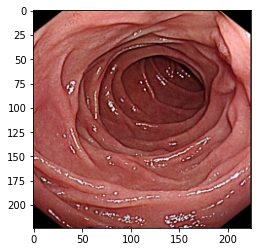

<built-in method type of Tensor object at 0x7ffaac1e6ea8>
(224, 224, 3)
[[[0.01176471 0.01176471 0.01176471]
  [0.02352941 0.00784314 0.01960784]
  [0.0627451  0.01568628 0.02745098]
  ...
  [0.01568628 0.01568628 0.01568628]
  [0.01568628 0.01568628 0.01568628]
  [0.01568628 0.01568628 0.01568628]]

 [[0.02352941 0.00784314 0.01960784]
  [0.03921569 0.01568628 0.02352941]
  [0.10588235 0.02352941 0.03137255]
  ...
  [0.02745098 0.04313726 0.01960784]
  [0.02352941 0.02352941 0.01176471]
  [0.03137255 0.01176471 0.02352941]]

 [[0.03137255 0.01176471 0.02352941]
  [0.07058824 0.02352941 0.02352941]
  [0.14901961 0.07058824 0.04705882]
  ...
  [0.10588235 0.07843138 0.03921569]
  [0.04705882 0.03921569 0.01960784]
  [0.01176471 0.02352941 0.03921569]]

 ...

 [[0.02352941 0.         0.01568628]
  [0.03529412 0.00784314 0.01568628]
  [0.07843138 0.02745098 0.01960784]
  ...
  [0.04705882 0.01568628 0.01176471]
  [0.03137255 0.01176471 0.02352941]
  [0.01176471 0.01568628 0.02352941]]

 [

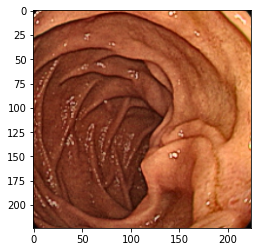

<built-in method type of Tensor object at 0x7ffaac1e6ea8>
(224, 224, 3)
[[[0.03137255 0.01176471 0.02352941]
  [0.01568628 0.01568628 0.01568628]
  [0.01568628 0.01568628 0.01568628]
  ...
  [0.01568628 0.01568628 0.01568628]
  [0.01568628 0.01568628 0.01568628]
  [0.01568628 0.01568628 0.01568628]]

 [[0.03137255 0.01176471 0.02352941]
  [0.01568628 0.01568628 0.01568628]
  [0.01568628 0.03921569 0.02352941]
  ...
  [0.03137255 0.01176471 0.02352941]
  [0.01176471 0.03529412 0.01960784]
  [0.01176471 0.03529412 0.01960784]]

 [[0.02745098 0.01176471 0.03529412]
  [0.03137255 0.01176471 0.02352941]
  [0.01568628 0.03921569 0.02352941]
  ...
  [0.01568628 0.01568628 0.01568628]
  [0.01176471 0.03529412 0.01960784]
  [0.01176471 0.03529412 0.01960784]]

 ...

 [[0.01568628 0.01568628 0.01568628]
  [0.01568628 0.01568628 0.01568628]
  [0.01568628 0.01568628 0.01568628]
  ...
  [0.01568628 0.01568628 0.01568628]
  [0.01568628 0.01568628 0.01568628]
  [0.01568628 0.01568628 0.01568628]]

 [

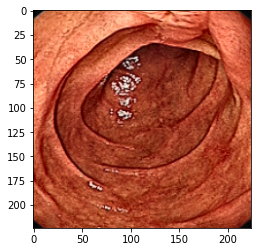

<built-in method type of Tensor object at 0x7ffaac1e6ea8>
(224, 224, 3)
[[[0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  ...
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]]

 [[0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  ...
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]]

 [[0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  ...
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]]

 ...

 [[0.01568628 0.01568628 0.01568628]
  [0.01568628 0.01568628 0.01568628]
  [0.01568628 0.01568628 0.01568628]
  ...
  [0.01568628 0.01568628 0.01568628]
  [0.01568628 0.01568628 0.01568628]
  [0.01568628 0.01568628 0.01568628]]

 [

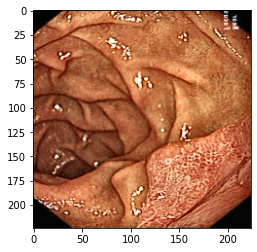

<built-in method type of Tensor object at 0x7ffaac1e6ea8>
(224, 224, 3)
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
tensor(0)


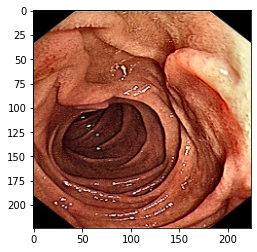

<built-in method type of Tensor object at 0x7ffaac1e6ea8>
(224, 224, 3)
[[[0.92941177 0.5686275  0.44313726]
  [0.9372549  0.5882353  0.4627451 ]
  [0.92156863 0.6        0.4627451 ]
  ...
  [0.5254902  0.20784314 0.13725491]
  [0.50980395 0.2        0.12941177]
  [0.5019608  0.1882353  0.12941177]]

 [[0.91764706 0.56078434 0.42745098]
  [0.9098039  0.5568628  0.43137255]
  [0.9019608  0.5647059  0.43137255]
  ...
  [0.53333336 0.21568628 0.14901961]
  [0.5058824  0.19607843 0.12941177]
  [0.5019608  0.18431373 0.12941177]]

 [[0.9098039  0.5529412  0.42352942]
  [0.9137255  0.5568628  0.42745098]
  [0.9019608  0.5568628  0.41960785]
  ...
  [0.5411765  0.22352941 0.15686275]
  [0.5137255  0.20392157 0.14117648]
  [0.50980395 0.19607843 0.14117648]]

 ...

 [[0.6156863  0.25882354 0.16470589]
  [0.59607846 0.22745098 0.15294118]
  [0.5882353  0.21960784 0.15294118]
  ...
  [0.32156864 0.13333334 0.12941177]
  [0.27450982 0.12941177 0.09803922]
  [0.34509805 0.22745098 0.18039216]]

 [

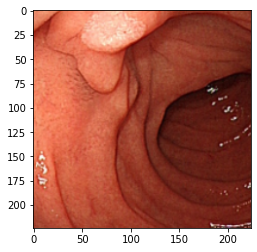

<built-in method type of Tensor object at 0x7ffaac1e6ea8>
(224, 224, 3)
[[[0.         0.         0.        ]
  [0.00393701 0.         0.00393701]
  [0.00393701 0.         0.00393701]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.00393701 0.        ]
  ...
  [0.         0.00393701 0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.00393701]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [

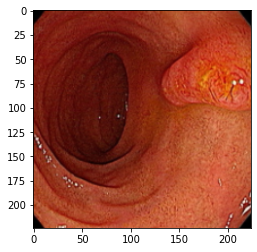

<built-in method type of Tensor object at 0x7ffaac1e6ea8>
(224, 224, 3)
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
tensor(0)


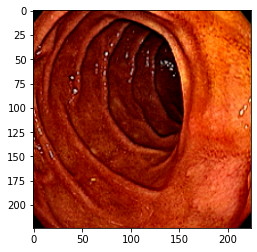

<built-in method type of Tensor object at 0x7ffaac1e6ea8>
(224, 224, 3)
[[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.00392157 0.         0.        ]
  [0.00392157 0.         0.        ]
  [0.00392157 0.         0.00784314]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.00392157 0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.00392157 0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.00392157 0.        ]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [

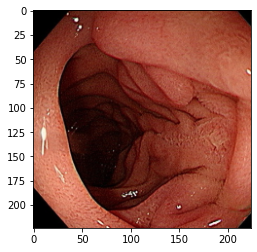

<built-in method type of Tensor object at 0x7ffaac1e6ea8>
(224, 224, 3)
[[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.00392157 0.        ]
  [0.         0.00392157 0.        ]
  [0.         0.         0.        ]]

 [

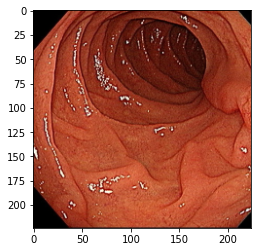

<built-in method type of Tensor object at 0x7ffaac1e6ea8>
(224, 224, 3)
[[[0.54112554 0.24242425 0.15151516]
  [0.6969697  0.32467532 0.19480519]
  [0.74458873 0.33333334 0.2034632 ]
  ...
  [0.83549786 0.45887446 0.24242425]
  [0.6839827  0.35064936 0.21212122]
  [0.44155845 0.23376623 0.17748918]]

 [[0.6666667  0.2943723  0.17748918]
  [0.72727275 0.32900432 0.20779221]
  [0.74025977 0.33333334 0.20779221]
  ...
  [0.86580086 0.4978355  0.27705628]
  [0.7835498  0.4199134  0.23376623]
  [0.6450216  0.33766234 0.20779221]]

 [[0.72727275 0.32467532 0.20779221]
  [0.7316017  0.32900432 0.22077923]
  [0.74025977 0.33766234 0.21645021]
  ...
  [0.8787879  0.5151515  0.3030303 ]
  [0.83549786 0.46753246 0.25974026]
  [0.7748918  0.4199134  0.23376623]]

 ...

 [[0.6103896  0.25974026 0.18614718]
  [0.66233766 0.27705628 0.17748918]
  [0.66233766 0.25541127 0.15151516]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [0.991342   0.991342   0.965368  ]]

 [

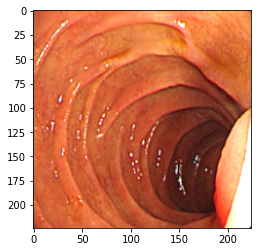

<built-in method type of Tensor object at 0x7ffaac1e6ea8>
(224, 224, 3)
[[[0.01176471 0.         0.01568628]
  [0.03529412 0.01176471 0.01176471]
  [0.11372549 0.05098039 0.03529412]
  ...
  [0.09803922 0.0627451  0.05098039]
  [0.02352941 0.01176471 0.00784314]
  [0.01568628 0.00392157 0.00392157]]

 [[0.02745098 0.00392157 0.01176471]
  [0.08235294 0.03529412 0.02352941]
  [0.20784314 0.11372549 0.08627451]
  ...
  [0.28627452 0.22745098 0.18431373]
  [0.08627451 0.05490196 0.03921569]
  [0.02745098 0.00784314 0.00784314]]

 [[0.07450981 0.01960784 0.00784314]
  [0.16470589 0.07450981 0.03921569]
  [0.28235295 0.15686275 0.10588235]
  ...
  [0.6        0.5058824  0.3882353 ]
  [0.23529412 0.17254902 0.1254902 ]
  [0.05882353 0.03137255 0.02745098]]

 ...

 [[0.01960784 0.         0.        ]
  [0.04705882 0.01176471 0.00784314]
  [0.09411765 0.04313726 0.03529412]
  ...
  [0.30980393 0.25490198 0.18431373]
  [0.07058824 0.05098039 0.03137255]
  [0.01176471 0.00784314 0.00784314]]

 [

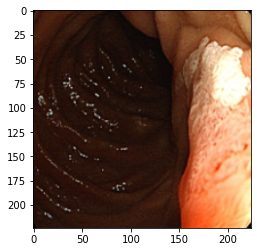

3
<built-in method type of Tensor object at 0x7ffaac601638>
(224, 224, 3)
[[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.00392157 0.         0.        ]
  [0.00392157 0.         0.        ]
  [0.         0.         0.00784314]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.00392157 0.        ]
  [0.         0.00392157 0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]



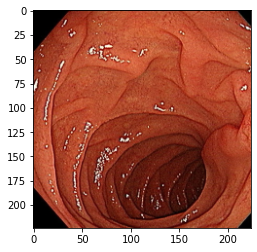

<built-in method type of Tensor object at 0x7ffaac601638>
(224, 224, 3)
[[[0.00784314 0.01176471 0.01960784]
  [0.00784314 0.01176471 0.01960784]
  [0.02352941 0.00784314 0.01960784]
  ...
  [0.02352941 0.00784314 0.01960784]
  [0.02352941 0.00784314 0.01960784]
  [0.00784314 0.01176471 0.01960784]]

 [[0.00784314 0.01176471 0.01960784]
  [0.00784314 0.01176471 0.01960784]
  [0.02352941 0.00784314 0.01960784]
  ...
  [0.02352941 0.00784314 0.01960784]
  [0.02352941 0.00784314 0.01960784]
  [0.00784314 0.01176471 0.01960784]]

 [[0.00784314 0.01176471 0.01960784]
  [0.00784314 0.01176471 0.01960784]
  [0.02352941 0.00784314 0.01960784]
  ...
  [0.02352941 0.00784314 0.01960784]
  [0.02352941 0.00784314 0.01960784]
  [0.00784314 0.01176471 0.01960784]]

 ...

 [[0.00784314 0.01176471 0.01960784]
  [0.01960784 0.02352941 0.03137255]
  [0.02352941 0.02352941 0.02352941]
  ...
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]]

 [

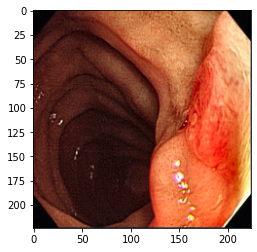

<built-in method type of Tensor object at 0x7ffaac601638>
(224, 224, 3)
[[[0.03349282 0.00478469 0.00478469]
  [0.06220096 0.00956938 0.00478469]
  [0.12440191 0.01435407 0.00956938]
  ...
  [0.02392345 0.00478469 0.00956938]
  [0.00956938 0.00478469 0.00478469]
  [0.00956938 0.00478469 0.        ]]

 [[0.08612441 0.00478469 0.00478469]
  [0.16267942 0.01435407 0.01435407]
  [0.2631579  0.05741627 0.0430622 ]
  ...
  [0.08612441 0.01435407 0.01435407]
  [0.02870813 0.00478469 0.00478469]
  [0.01435407 0.00478469 0.00478469]]

 [[0.18660288 0.02870813 0.02392345]
  [0.31578946 0.07655502 0.05741627]
  [0.43540668 0.13875598 0.09569378]
  ...
  [0.22488038 0.06698564 0.05741627]
  [0.10526316 0.02392345 0.01913876]
  [0.0430622  0.00478469 0.01435407]]

 ...

 [[0.09569378 0.03349282 0.02392345]
  [0.2631579  0.13875598 0.11004785]
  [0.5167464  0.31578946 0.25358853]
  ...
  [0.17224881 0.16267942 0.16267942]
  [0.0430622  0.03827751 0.03827751]
  [0.00478469 0.00478469 0.00478469]]

 [

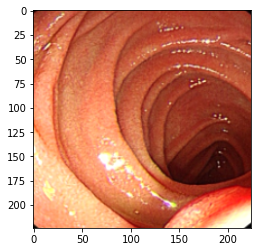

<built-in method type of Tensor object at 0x7ffaac601638>
(224, 224, 3)
[[[0.5256917  0.18577075 0.08695652]
  [0.541502   0.19367589 0.09486166]
  [0.5494071  0.19762845 0.1027668 ]
  ...
  [0.7786561  0.32806325 0.16205534]
  [0.80237156 0.34387353 0.18577075]
  [0.7549407  0.33596838 0.18577075]]

 [[0.5335968  0.19762845 0.09881423]
  [0.53754944 0.19367589 0.09090909]
  [0.541502   0.18972331 0.09486166]
  ...
  [0.770751   0.31620553 0.13438736]
  [0.7905138  0.3320158  0.15019763]
  [0.8102767  0.3715415  0.19762845]]

 [[0.5494071  0.21343873 0.11462451]
  [0.5335968  0.18972331 0.09090909]
  [0.541502   0.19367589 0.09486166]
  ...
  [0.78656125 0.33596838 0.13833992]
  [0.76679844 0.31225297 0.10671937]
  [0.7826087  0.33596838 0.13833992]]

 ...

 [[0.5217391  0.17786561 0.06324111]
  [0.5494071  0.18577075 0.07905138]
  [0.5731225  0.19762845 0.09486166]
  ...
  [0.8695652  0.4743083  0.26482213]
  [0.8695652  0.48221344 0.2806324 ]
  [0.8853755  0.49407116 0.2964427 ]]

 [

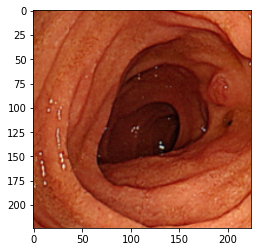

<built-in method type of Tensor object at 0x7ffaac601638>
(224, 224, 3)
[[[0.01568628 0.01568628 0.01568628]
  [0.01568628 0.01568628 0.01568628]
  [0.01176471 0.01568628 0.02352941]
  ...
  [0.01568628 0.01568628 0.01568628]
  [0.02352941 0.01568628 0.00784314]
  [0.02352941 0.01568628 0.00784314]]

 [[0.01568628 0.01568628 0.01568628]
  [0.01176471 0.01568628 0.02352941]
  [0.02352941 0.02352941 0.02352941]
  ...
  [0.03137255 0.01176471 0.02352941]
  [0.01568628 0.01568628 0.01568628]
  [0.01568628 0.01568628 0.01568628]]

 [[0.02352941 0.02352941 0.02352941]
  [0.02745098 0.03529412 0.04313726]
  [0.08235294 0.03921569 0.03921569]
  ...
  [0.02352941 0.02745098 0.02745098]
  [0.01568628 0.01568628 0.01568628]
  [0.01568628 0.01568628 0.01568628]]

 ...

 [[0.9098039  0.7294118  0.5058824 ]
  [0.92941177 0.7764706  0.5647059 ]
  [0.92156863 0.77254903 0.54509807]
  ...
  [0.4392157  0.02352941 0.        ]
  [0.45490196 0.04705882 0.        ]
  [0.39607844 0.00784314 0.        ]]

 [

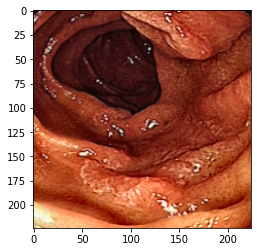

<built-in method type of Tensor object at 0x7ffaac601638>
(224, 224, 3)
[[[0.01310044 0.01310044 0.01310044]
  [0.01310044 0.01310044 0.01310044]
  [0.01310044 0.01310044 0.01310044]
  ...
  [0.02620087 0.02620087 0.02620087]
  [0.01310044 0.01310044 0.01310044]
  [0.01310044 0.01310044 0.01310044]]

 [[0.01310044 0.01310044 0.01310044]
  [0.01310044 0.01310044 0.01310044]
  [0.01310044 0.01310044 0.01310044]
  ...
  [0.02620087 0.02620087 0.02620087]
  [0.01310044 0.01310044 0.01310044]
  [0.01310044 0.01310044 0.01310044]]

 [[0.02620087 0.00873362 0.02183406]
  [0.02620087 0.00873362 0.02183406]
  [0.01746725 0.01746725 0.01746725]
  ...
  [0.02620087 0.02620087 0.02620087]
  [0.02620087 0.00873362 0.02183406]
  [0.02620087 0.02620087 0.02620087]]

 ...

 [[0.35371178 0.2183406  0.20087336]
  [0.55458516 0.40611354 0.36681223]
  [0.6768559  0.5152838  0.48034933]
  ...
  [0.7947598  0.48908296 0.31441048]
  [0.78165936 0.5021834  0.30567685]
  [0.77292573 0.46724892 0.29257643]]

 [

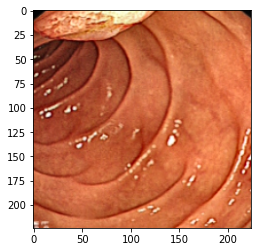

<built-in method type of Tensor object at 0x7ffaac601638>
(224, 224, 3)
[[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.00403226]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [

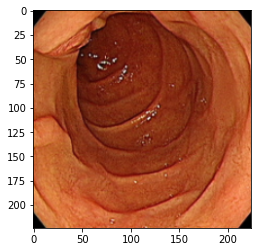

<built-in method type of Tensor object at 0x7ffaac601638>
(224, 224, 3)
[[[0.01214575 0.01214575 0.01214575]
  [0.01214575 0.01214575 0.01214575]
  [0.01214575 0.01214575 0.01214575]
  ...
  [0.01214575 0.01214575 0.01214575]
  [0.01214575 0.01214575 0.01214575]
  [0.01214575 0.01214575 0.01214575]]

 [[0.01214575 0.01214575 0.01214575]
  [0.01214575 0.01214575 0.01214575]
  [0.01214575 0.01214575 0.01214575]
  ...
  [0.01214575 0.01214575 0.01214575]
  [0.01214575 0.01214575 0.01214575]
  [0.01214575 0.01214575 0.01214575]]

 [[0.01214575 0.01214575 0.01214575]
  [0.01214575 0.01214575 0.01214575]
  [0.01214575 0.01214575 0.01214575]
  ...
  [0.01214575 0.01214575 0.01214575]
  [0.01214575 0.01214575 0.01214575]
  [0.01214575 0.01214575 0.01214575]]

 ...

 [[0.01214575 0.01214575 0.01214575]
  [0.01214575 0.01214575 0.01214575]
  [0.01214575 0.01214575 0.01214575]
  ...
  [0.01214575 0.01214575 0.01214575]
  [0.01214575 0.01214575 0.01214575]
  [0.01214575 0.01214575 0.01214575]]

 [

KeyboardInterrupt: 

In [23]:
import os
import cv2
import numpy as np

#이미지를 numpy형식으로 바꾸어주고 transpose를 통해 수정해주는 과정을 람다형식으로 정의
fn_tonumpy = lambda x : x.to('cpu').detach().numpy().transpose(0,2,3,1)
for batch_idx, i in enumerate(train_dataloader):
    print(batch_idx+1)
    for a in range(batch_size):
        img = i['img']
        label = i['label']
        print(label.type)
#         filename = i['filename']
        #     filename = i['filename']
        img = fn_tonumpy(img)[a]
        #     print(filename)
        print(img.shape)
        print(img)
#         print(filename[a])
        print(label[a])
        plt.imshow(img)
        plt.show()

In [24]:
from torchvision import models
import torch
import timm
# m = timm.create_model('seresnet50', pretrained=True)

seresnet50_pretrained = timm.create_model('seresnet50', pretrained=True)
print(seresnet50_pretrained)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [25]:
num_classes = 1
num_features = seresnet50_pretrained.fc.in_features
seresnet50_pretrained.fc = nn.Linear(num_features, num_classes)

seresnet50_pretrained

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [26]:
GPU_NUM = 0
os.environ["CUDA_VISIBLE_DEVICES"]='1'
print('gpu? ', torch.cuda.is_available())
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
print('Current gpu: ', torch.cuda.current_device())

if device.type == 'cuda':
    print('Allocated:', round(torch.cuda.memory_allocated(GPU_NUM)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(GPU_NUM)/1024**3,1), 'GB')
    
model = seresnet50_pretrained.to(device)
x = torch.randn(3, 3, 224, 224).to(device)
output = model(x)
print(output)

gpu?  True
Current gpu:  0
Allocated: 0.0 GB
Cached:    0.0 GB


/home/crop2292/anaconda3/envs/hoon/lib/python3.6/site-packages/torch/cuda/memory.py:386: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


tensor([[-0.0411],
        [-0.0124],
        [-0.0165]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [23]:
#summary(model, (3, 409, 465), device=device.type)

In [27]:
# 손실함수 정의(loss function) 
# 크로스 엔트로피 : 실제 값과 예측 값의 차이를 줄이기 위한 엔트로피
# 다중 클래스 문제에서 잘 작동
# loss_func = nn.BCEWithLogitsLoss()


# 옵티마이저 : Adam 
# model(신경망) 파라미터를 optimizer에 전달해줄 때 nn.Module의 parameters() 메소드를 사용
# Karpathy's learning rate 사용 (3e-4)
opt = optim.Adam(model.parameters(), lr=0.0001)
#scheduler
from torch.optim.lr_scheduler import ExponentialLR
lr_scheduler = ExponentialLR(opt, gamma=0.95)

In [28]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

In [29]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.65):
        super(FocalLoss, self).__init__()
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = self.loss_fn.reduction  # mean, sum, etc..

    def forward(self, pred, true):
        bceloss = self.loss_fn(pred, true)

        pred_prob = torch.sigmoid(pred)  # p  pt는 p가 true 이면 pt = p / false 이면 pt = 1 - p
        alpha_factor = true * self.alpha + (1-true) * (1 - self.alpha)  # add balance
        modulating_factor = torch.abs(true - pred_prob) ** self.gamma  # focal term
        loss = alpha_factor * modulating_factor * bceloss  # bceloss에 이미 음수가 들어가 있음
        
        if self.reduction == 'mean':
            return loss.mean()
        
        elif self.reduction == 'sum':
            return loss.sum()
        
        else:  # 'none'
            return loss

In [30]:
def metric_batch(output, target):
    #max함수 안의 1 : 어느방향으로 max값을 찾을지를 의미. 
    output_sig = torch.sigmoid(output)
    y_pred = output_sig.cpu()
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = 0
    
    preds_batch_list = []
    y_pred_list = y_pred.detach().cpu().numpy().tolist()
    preds_batch_list.append(y_pred_list)
    
    labels_batch_list =[]
    labels_list = target.detach().cpu().numpy().tolist()
    labels_batch_list.append(labels_list)
    
    correct_num = y_pred.eq(target.cpu()).int().sum()
    
    # https://junstar92.tistory.com/121
    #https://bigdatadiary0819.tistory.com/54
#     corrects = pred.eq(target).sum().item()
    return correct_num, preds_batch_list,labels_batch_list


# function to calculate loss per mini-batch
def loss_batch(output, target, opt=None):
    
    
#     target = torch.FloatTensor(target)
#     print(output)
#     print(target)
    

# 여기서 target값은 1차원이기 때문에 마지막 layer에서 나오는 결과를 1개의 출력으로
    fl_loss = FocalLoss().forward(output, target)
    metric_b, preds_batch_list,labels_batch_list = metric_batch(output, target)

#     배치 사이즈 만큼의 데이터가 들어가서 forward train을 하고 backward로 
#     optimize를 진행합니다. 이게 1step 
#     step마다 계산된 가중치를 다시 제로로 만들고 다음 배치 데이터를 
#     forward/backward해야 하므로 optimizer.zero_grad를 꼭 넣어준다.
    if opt is not None:
        opt.zero_grad()
        fl_loss.backward()
        opt.step()

    return fl_loss.item(), metric_b, preds_batch_list,labels_batch_list

In [31]:
def loss_epoch(model, dataset_dl, sanity_check=False, opt=None):
    #sanity_check가 true인 경우 1epoch만 학습하고 더이상 학습하지 않는다.
    running_loss = 0.0
    running_metric = 0.0
    len_dataset_dl = len(dataset_dl)
    len_dataset = len(dataset_dl.dataset)
    preds_running_list = []
    labels_running_list = []
#     print(len_data)
#     print(len(dataset_dl))
    
    
    for data in dataset_dl:
#         inputs = data
#     for a in range (i):
        inputs = data['img']
#         print(inputs.shape)
        labels = data['label']
#         print(labels.shape)
        inputs = inputs.to(device)
        labels = labels.to(device, dtype = torch.float32)
        output = torch.squeeze(model(inputs))
    
#     for i, data in enumerate(dataset_dl):
#         inputs = data
#      for a in range (i):
#         inputs = data['img']
#          print(inputs.shape)
#         labels = data['label']
#          print(labels.shape)
#         inputs = inputs.to(device)
#         labels = labels.to(device)
#         output = model(inputs)

#         print(inputs.type)
#         print(output.type)
#         print(labels.type)
        
        
        loss_b, metric_b, preds_batch_list,labels_batch_list = loss_batch(output, labels, opt)

        running_loss += loss_b
        preds_running_list.extend(preds_batch_list)
        labels_running_list.extend(labels_batch_list)

        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break
            
    average_loss = running_loss / len_dataset_dl
    average_metric = running_metric / len_dataset
#     print(average_loss)
    
    return average_loss, average_metric, preds_running_list, labels_running_list      

In [32]:
# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    #가장 잘 나온 weight를 저장.
    best_model_wts = copy.deepcopy(model.state_dict())

    #This is useful for finding lowest values for something.
    best_loss = float('inf')

    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch+1, num_epochs, current_lr))

        model.train()
        train_loss, train_metric, preds_train_list, labels_train_list = loss_epoch(model, train_dl, sanity_check, opt)
        #epoch마다 loss값과 정확도 값 확인
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)
        
        # confusion matrix를 그리기 위해 label과 prediction한 결과를 한곳으로 모아주기
        preds_train_list_sum = sum(preds_train_list,[])
        labels_train_list_sum = sum(labels_train_list,[])
        
        lr_scheduler.step()
# model.eval() : 해당 모델의 모든 레이어가 evaluation model에 들어가게 해주는 것. 
# 학습할 때만 필요한 dropout, batchnorm등의 기능을 비황성화 시키는 것.
# torch.no_grad() : gradient계산 context를 비활성화 해주는 역할.    
        model.eval()
    
        # valid data
        with torch.no_grad():
            val_loss, val_metric, preds_val_list, labels_val_list = loss_epoch(model, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')
            print('Get best val_loss')

        


        train_accuracy = 100*train_metric
        val_accuracy = 100*val_metric
        
        writer.add_scalar('Loss/train', train_loss, epoch+1)
        writer.add_scalar('Loss/val', val_loss, epoch+1)
        writer.add_scalar('Accuracy/train', train_accuracy, epoch+1)
        writer.add_scalar('Accuracy/val', val_accuracy, epoch+1)
        
        print('train loss: %.6f , accuracy: %.2f, time: %.4f min' %(train_loss, train_accuracy, (time.time()-start_time)/60))
        print('val loss: %.6f , accuracy: %.2f, time: %.4f min' %(val_loss, val_accuracy, (time.time()-start_time)/60))
        
        preds_val_list_sum = sum(preds_val_list, [])
        labels_val_list_sum = sum(labels_val_list, [])
#         print(preds_val_list)
#         print(len(preds_val_list))
#         print(labels_val_list)
#         print(len(labels_val_list))
        
        print('train_confusion_matrix')
        print(confusion_matrix(labels_train_list_sum,preds_train_list_sum))
        print('val_confustion_matrix')
        print(confusion_matrix(labels_val_list_sum,preds_val_list_sum))
        print(classification_report(labels_val_list_sum,preds_val_list_sum))
        print(accuracy_score(labels_val_list_sum,preds_val_list_sum))
        print('-'*30)

        model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

In [33]:
params_train = {
    'num_epochs':150,
    'optimizer':opt,
    'train_dl':train_dataloader,
    'val_dl':valid_dataloader,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'/mnt/nas100_vol2/LeeJungHoon/AOV_task(binary_clssification)/Model_V2/weights_file/SeResnet50(b=16,Adam,Focal_alpha(0.65),WRS,sche,seed,7,pre,AUG,re)_weights_pt',
}

#만약 파일이 존재하지 않으면 새로운 파일 생성
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('Resnet_weights_pt')

In [34]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('/mnt/nas100_vol2/LeeJungHoon/AOV_task(binary_clssification)/Model_V2/runs/SeResnet50(b=16,Adam,Focal_alpha(0.65),WRS,sche,seed,7,pre,AUG,re)')

In [35]:
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 1/150, current lr=0.0001
Copied best model weights!
Get best val_loss
train loss: 0.065612 , accuracy: 64.98, time: 0.3632 min
val loss: 0.054264 , accuracy: 61.76, time: 0.3632 min
train_confusion_matrix
[[157 215]
 [ 55 344]]
val_confustion_matrix
[[39 56]
 [ 9 66]]
              precision    recall  f1-score   support

         0.0       0.81      0.41      0.55        95
         1.0       0.54      0.88      0.67        75

    accuracy                           0.62       170
   macro avg       0.68      0.65      0.61       170
weighted avg       0.69      0.62      0.60       170

0.6176470588235294
------------------------------
Epoch 2/150, current lr=9.5e-05
Copied best model weights!
Get best val_loss
train loss: 0.035695 , accuracy: 79.25, time: 0.6765 min
val loss: 0.037073 , accuracy: 75.29, time: 0.6765 min
train_confusion_matrix
[[255 123]
 [ 37 356]]
val_confustion_matrix
[[72 23]
 [19 56]]
              precision    recall  f1-score   support

         0.0     

Text(0.5, 1.0, 'loss')

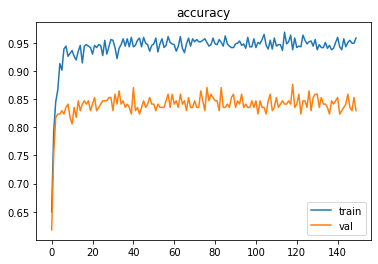

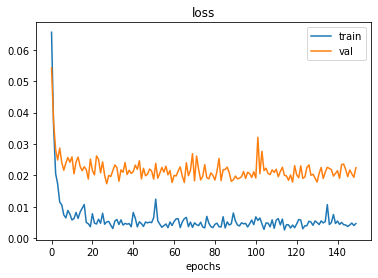

In [36]:
accuracy = metric_hist['train']
val_accuracy = metric_hist['val'] 

loss = loss_hist['train'] 
val_loss = loss_hist['val']

epochs = range(len(loss_hist['train']))

plt.plot(epochs, accuracy, label="train") 
plt.plot(epochs, val_accuracy, label="val") 
plt.legend() 
plt.title('accuracy') 

plt.figure() 
plt.plot(epochs, loss, label="train")
plt.xlabel('epochs')

plt.plot(epochs, val_loss, label="val") 
plt.xlabel('epochs')
plt.legend() 
plt.title('loss')

In [37]:
model_name = 'SeResnet50(b=16,Adam,Focal_alpha(0.65),WRS,sche,seed,7,pre,AUG,re)_weights_pt'
model_path = '/mnt/nas100_vol2/LeeJungHoon/AOV_task(binary_clssification)/Model_V2/weights_file/'

In [38]:
model = seresnet50_pretrained.to(device)
model.load_state_dict(torch.load(model_path + model_name))

<All keys matched successfully>

In [39]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# output = model(input_data)
model.eval()  

test_accuracy = 0.0
running_accuracy = 0.0
len_dataset = len(test_dataloader.dataset)
pred = []
label = []
outputs = []
incorrect_normal_list = []
incorrect_abnormal_list = []

# valid data
with torch.no_grad():
    for data in test_dataloader:
        
        inputs = data['img']
        labels = data['label']
        idx = data['filename']
        
        inputs = inputs.to(device)
        labels = labels.to(device, dtype = torch.float32)
        print(model(inputs))
        
        output = torch.squeeze(model(inputs))
        output_sig = torch.sigmoid(output)
        outputs.append(output_sig.cpu())
        y_pred = output_sig.cpu()
        y_pred[y_pred >= 0.5] = 1
        y_pred[y_pred < 0.5] = 0
        
        if y_pred != labels.cpu():
            if labels.cpu() == 1:
                incorrect_abnormal_list.append(idx)
            else:
                incorrect_normal_list.append(idx)
                
            
        
        
        y_pred_ = y_pred.detach().cpu().numpy().tolist()
        print(y_pred_)
        
        correct_num = y_pred.eq(labels.cpu()).int().sum()
        running_accuracy += correct_num
        print(correct_num)
        
        labels_numpy = labels.detach().cpu().numpy().tolist()
        print(labels_numpy)
        
        
        pred.append(y_pred_)
        label.append(labels_numpy)
        
#         print(confusion_matrix(y_pred,labels_numpy))
#         print(classification_report(y_pred,labels_numpy))
#         print(accuracy_score(y_pred,labels_numpy))

test_accuracy = running_accuracy / len_dataset


tensor([[-1.4762]], device='cuda:0')
0.0
tensor(1)
[0.0]
tensor([[-3.8289]], device='cuda:0')
0.0
tensor(1)
[0.0]
tensor([[-2.6762]], device='cuda:0')
0.0
tensor(1)
[0.0]
tensor([[-3.9513]], device='cuda:0')
0.0
tensor(1)
[0.0]
tensor([[-1.5391]], device='cuda:0')
0.0
tensor(1)
[0.0]
tensor([[-3.6005]], device='cuda:0')
0.0
tensor(1)
[0.0]
tensor([[-2.5932]], device='cuda:0')
0.0
tensor(1)
[0.0]
tensor([[-3.7301]], device='cuda:0')
0.0
tensor(1)
[0.0]
tensor([[-3.0096]], device='cuda:0')
0.0
tensor(1)
[0.0]
tensor([[-4.3980]], device='cuda:0')
0.0
tensor(1)
[0.0]
tensor([[-4.7162]], device='cuda:0')
0.0
tensor(1)
[0.0]
tensor([[-5.6386]], device='cuda:0')
0.0
tensor(1)
[0.0]
tensor([[-0.9617]], device='cuda:0')
0.0
tensor(1)
[0.0]
tensor([[1.1381]], device='cuda:0')
1.0
tensor(0)
[0.0]
tensor([[-2.9226]], device='cuda:0')
0.0
tensor(1)
[0.0]
tensor([[-1.2572]], device='cuda:0')
0.0
tensor(1)
[0.0]
tensor([[-1.9266]], device='cuda:0')
0.0
tensor(1)
[0.0]
tensor([[-1.5803]], device='cuda

In [40]:
from sklearn.metrics import roc_curve
from numpy import argmax

# calculate roc curves
fpr, tpr, thresholds = roc_curve(label, outputs)

# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f, sensitivity = %.3f, specificity = %.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

print(confusion_matrix(label,pred))
print(classification_report(label,pred))
cm = confusion_matrix(label,pred)

Best Threshold=0.649325, sensitivity = 0.846, specificity = 0.908, J=0.754
[[63 13]
 [10 68]]
              precision    recall  f1-score   support

         0.0       0.86      0.83      0.85        76
         1.0       0.84      0.87      0.86        78

    accuracy                           0.85       154
   macro avg       0.85      0.85      0.85       154
weighted avg       0.85      0.85      0.85       154



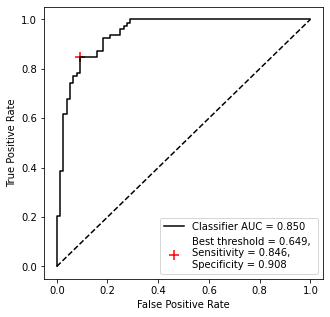

In [41]:
from sklearn.metrics import roc_auc_score

#plot roc and best threshold
sens, spec = tpr[ix], 1-fpr[ix]
# plot the roc curve for the model
plt.figure(figsize=(5,5))
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')
plt.plot(fpr, tpr, marker='.', color='black', markersize=0.05, label="Classifier AUC = %.3f" % roc_auc_score(label, pred))
plt.scatter(fpr[ix], tpr[ix], marker='+', s=100, color='r', 
            label='Best threshold = %.3f, \nSensitivity = %.3f, \nSpecificity = %.3f' % (best_thresh, sens, spec))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)

# show the plot
plt.show()

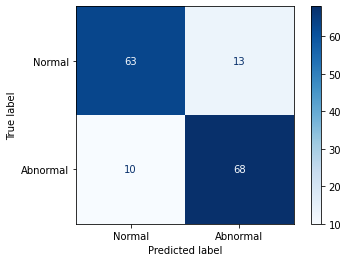

In [42]:
 from sklearn.metrics import ConfusionMatrixDisplay
# 라벨 설정
label_name = ['Normal', 'Abnormal'] 
disp = ConfusionMatrixDisplay(cm, # 분류 모델
                             display_labels=label_name, # 표에 표시할 labels
                             ) # 'true', 'pred', 'all' 중에서 지정 가능. default=None
disp.plot(cmap = plt.cm.Blues)